In [165]:
import cv2
import numpy as np
import pandas as pd
from scipy.signal import convolve2d
import math
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import time

In [166]:
def disk_kernel(radius:float)->np.array:
    size = 2*math.ceil(radius) +1
    kernel = np.zeros((size,size))
    a = size //2
    for i in range(size):
        for j in range(size):
            x = i-a
            y = j-a
            distance = np.sqrt(x**2 + y**2)
            if(distance <=radius-0.5):
                kernel[i,j] = 1
            elif(distance >= radius-0.5 and distance <= radius +0.5):
                kernel[i,j] = np.round(radius +0.5 - distance,3)
            else:
                kernel[i,j] = 0
    return kernel

def convolve(image:np.array,kernel:np.array)->np.array:
    x,y = image.shape[0]//2,image.shape[1]//2
    image_shape = image.shape
    padded_image = np.pad(image,((image_shape[0]//2,image_shape[0]//2),(image_shape[1]//2,image_shape[1]//2)),mode='reflect')

    convolved_image =convolve2d(padded_image,kernel,mode='same')
    out_image = convolved_image[x:x+image.shape[0],y:y+image.shape[1]]
    out_image =((out_image - np.min(out_image))/(np.max(out_image)-np.min(out_image)) *255).astype(np.uint8)
    return out_image.astype(np.uint8)

#########################################################################
def blur_using_fft(image:np.array,kernel:np.array,intermediate=False)->np.array:
    image_shape = image.shape
    padded_image = np.pad(image,((image_shape[0]//2,image_shape[0]//2),(image_shape[1]//2,image_shape[1]//2)),mode='reflect')
    padded_kernel = np.zeros(padded_image.shape)
    padded_kernel[(padded_kernel.shape[0] // 2 - kernel.shape[0] // 2):(padded_kernel.shape[0] // 2 + kernel.shape[0] // 2 + 1), 
                  (padded_kernel.shape[1] // 2 - kernel.shape[1] // 2):(padded_kernel.shape[1] // 2 + kernel.shape[1] // 2 + 1)] = kernel
    padded_kernel = fftshift(padded_kernel)
    F_image = fft2(padded_image)
    F_kernel = fft2(padded_kernel)
    Image_filtered = F_image*F_kernel
    inversed = np.real(ifft2(Image_filtered))
    x,y = image_shape[0]//2,image_shape[1]//2
    out_image =inversed[x:x+image_shape[0],y:y+image_shape[1]]
    out_image =((out_image - np.min(out_image))/(np.max(out_image)-np.min(out_image)) *255).astype(np.uint8)

    if(intermediate):

        log_spectrum_shifted = np.log(np.abs(fftshift(F_image)))
        log_spectrum_shifted = (255*(log_spectrum_shifted - np.min(log_spectrum_shifted))/(np.max(log_spectrum_shifted) - np.min(log_spectrum_shifted))).astype(np.uint8)
        cv2.imwrite("output_images/Q1/Q1_b_shifted_spectrum.png",log_spectrum_shifted,[cv2.IMWRITE_PNG_COMPRESSION,0])
        log_shifted_filtered =  np.log(np.abs(fftshift(Image_filtered)))
        log_shifted_filtered = (255*(log_shifted_filtered - np.min(log_shifted_filtered))/(np.max(log_shifted_filtered) - np.min(log_shifted_filtered))).astype(np.uint8)
        cv2.imwrite("output_images/Q1/Q1_b_shifted_filtered_image.png",log_shifted_filtered,[cv2.IMWRITE_PNG_COMPRESSION,0])
        log_shifted_kernel = np.log(np.abs(fftshift(F_kernel)))
        log_shifted_kernel = 255*(log_shifted_kernel-np.min(log_shifted_kernel))/(np.max(log_shifted_kernel) - np.min(log_shifted_kernel))
        cv2.imwrite("output_images/Q1/Q1_b_shifted_kernel_image.png",log_shifted_kernel,[cv2.IMWRITE_PNG_COMPRESSION,0])

    return out_image.astype(np.uint8)


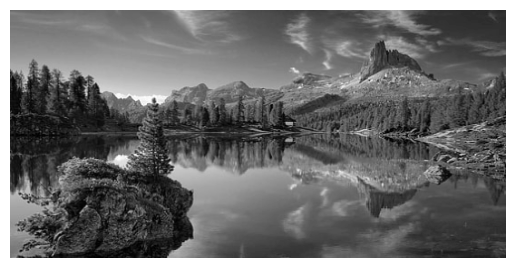

In [167]:
image1 = cv2.imread("data/img1.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image1, cmap='gray')

plt.axis('off') 
plt.show()

Q1 a image shape (250, 500)


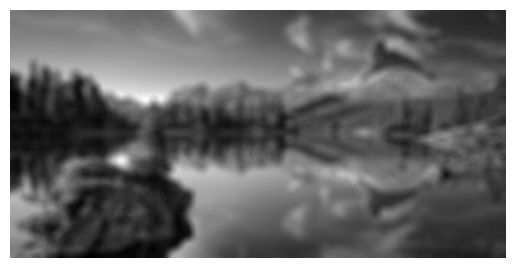

In [168]:
#******************Q1**************************
kernel1 = disk_kernel(5)
filtered_image1 = convolve(image1,kernel1)
cv2.imwrite("output_images/Q1/convolved_image.png",filtered_image1,[cv2.IMWRITE_PNG_COMPRESSION,0])
print("Q1 a image shape",filtered_image1.shape)
plt.imshow(filtered_image1, cmap='gray')
plt.axis('off')
plt.show()

Q1 a image shape (250, 500)


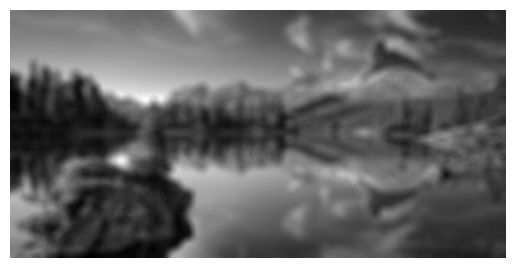

In [169]:
# image1 = cv2.imread("data/img1.png", cv2.IMREAD_GRAYSCALE)
filtered_image2 =blur_using_fft(image1,kernel1,True)
cv2.imwrite("output_images/Q1/blured_in_frequency_domain.png",filtered_image2,[cv2.IMWRITE_PNG_COMPRESSION,0])
print("Q1 a image shape",filtered_image2.shape)
plt.imshow(filtered_image2, cmap='gray')
plt.axis('off')
plt.show()

In [170]:
z=(filtered_image2==filtered_image1) 
p = (z==True)
print("equal values should be ",250*500," equal values ",np.sum(np.array(z)))

equal values should be  125000  equal values  125000


In [171]:
#Q1 d computing execution time
r=1
T_r =0
time_convolution =[]
time_fft =[]
R_list =[]
L=np.minimum(image1.shape[0],image1.shape[1])
while r < L and T_r <= 1.0:
    kernel = disk_kernel(r)
    start = time.time()
    convolve(image1,kernel)
    start2 = time.time()
    blur_using_fft(image1,kernel)
    start3 = time.time()
    t1 = start2 - start
    t2 = start3 - start2
    time_convolution.append(t1)
    time_fft.append(t2)
    T_r = np.maximum(t1,t2)
    R_list.append(r)
    r = r*2
print("time_convolution:",time_convolution)
print("time fft: ",time_fft)
print("Radius_list",R_list)
    

time_convolution: [0.01629328727722168, 0.026634931564331055, 0.08220291137695312, 0.19624924659729004, 0.6680924892425537, 2.7022616863250732]
time fft:  [0.022696495056152344, 0.019499778747558594, 0.01724410057067871, 0.017984390258789062, 0.01911187171936035, 0.017698287963867188]
Radius_list [1, 2, 4, 8, 16, 32]


In [172]:
time_convolution = np.array(time_convolution)
time_fft = np.array(time_fft)
R_list = np.array(R_list)

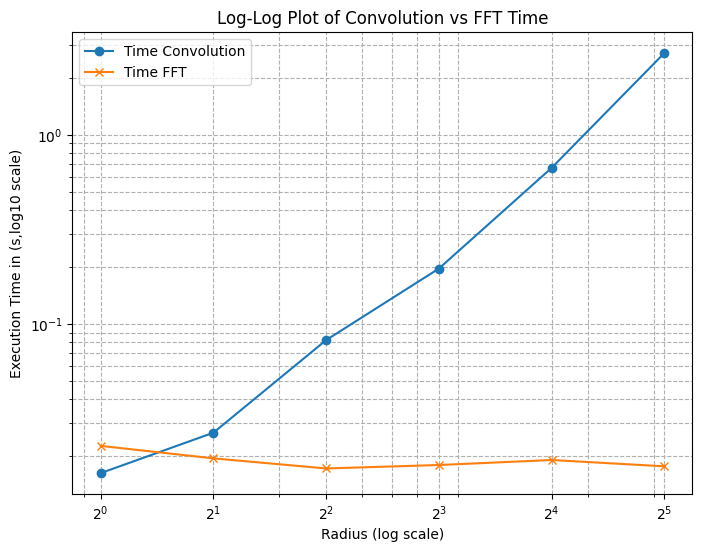

In [173]:
plt.figure(figsize=(8, 6))
plt.loglog(R_list, time_convolution, label='Time Convolution', marker='o')
plt.loglog(R_list, time_fft, label='Time FFT', marker='x')
plt.xlabel('Radius (log scale)')
plt.ylabel('Execution Time in (s,log10 scale)')
plt.title('Log-Log Plot of Convolution vs FFT Time')

plt.legend()
ticks = R_list
tick_labels = [f'$2^{int(np.log2(r))}$' for r in R_list]  # Format as 2^n

plt.xticks(ticks, tick_labels)

plt.grid(True, which="both", ls="--")
plt.savefig("output_images/Q1/plot.png")
plt.show()


In [174]:
# plt.savefig("output_images/Q1/plot.png")
plt.show()